# Prediction of trial epoch with 
Jan2024
@author:Ines

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase

one = ONE()

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/tmp6swkdtub/cache.zip Bytes: 118666494


100%|██████████| 113.16918754577637/113.16918754577637 [00:19<00:00,  5.88it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [14]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[2:3]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1'

    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [15]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

## Trial phase

In [16]:
bins_df = bins_per_trial_phase(design_matrix, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin')
melted = pd.melt(new_df, id_vars=['Bin', 'label', 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWar

## Auto-correlation per trial phase

In [17]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

new_df['Lick count'] = gaussian_filter1d(new_df['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
new_df['avg_wheel_vel'] = np.abs(new_df['avg_wheel_vel'])

## Labels

In [18]:
# --Remove NaNs and mouse column from design matrix

mat = new_df.drop(columns=['Bin', 'Trial', 'label'])
var = 'broader_label'
# var = 'label'
mat = mat.dropna()
mat = mat.drop_duplicates()
mat[var] = mat[var].replace(['Pre-choice', 'Choice', 'Post-choice'],
                 [1, 2, 3])

In [19]:
use_mat = mat.copy() 
# Downsample
# TODO: make this less hard-coded
label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), len(use_mat.loc[use_mat[var]==3])]
min_freq = np.min(label_freq)
labels = [1, 2, 3]
for label in labels:
    original_index = np.array(use_mat.loc[use_mat[var]==label].reset_index()['index'])
    use_index = np.random.choice(original_index, min_freq, replace=False)
    if label == 1:
        new_mat = use_mat[use_mat.index.isin(use_index)].copy()
    else:
        new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)].copy())
new_mat = new_mat.reset_index().drop(columns=['index'])



/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23458/1925585801.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)].copy())
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23458/1925585801.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)].copy())


In [20]:
labels = np.array(use_mat[var])
labels_nr = np.arange(labels.shape[0])
N_MICE = min_freq
# Randomly select N mice from each lab to equalize classes
use_index = np.empty(0, dtype=int)
for j, lab in enumerate(np.unique(labels)):
    use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == lab],
                                                            N_MICE, replace=False)])

In [21]:
"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice

shufflings = 100  #shuffling
repetitions = 10  # permutation repetitions
model = GaussianNB()
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

# Decoding function with 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
use_mat = mat.copy() # test using all mice

# Find minimum number of samples per label
labels = np.array(use_mat[var])
labels_nr = np.arange(labels.shape[0])
label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), len(use_mat.loc[use_mat[var]==3])]
min_freq = np.min(label_freq)

# Randomly select N mice from each lab to equalize classes
use_index = np.empty(0, dtype=int)
for j, epoch in enumerate(np.unique(labels)):
    use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                            min_freq, replace=False)])

new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
        
# -- ORIGINAL DATASET

dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

y_pred = np.zeros(len(new_mat), dtype=int) 
# exog = new_mat[new_mat.columns.difference([var])]
exog = new_mat[new_mat.columns.difference([var, 'correct', 'choice', 'signed_contrast'])]
endog = new_mat.loc[:, var]

for train_index, test_index in kf.split(new_mat):
    model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
    y_pred[test_index] = model.predict(exog.iloc[test_index])

# Calculate f1 score and confusion matrix
f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

# Save results
dec_result.loc[0, 'f1'] = f1
dec_result.loc[0, 'confusion_matrix'] = cm
dec_result.loc[0, 'shuffle'] = 0

decoding_result = pd.concat([decoding_result, dec_result])


# -- DETERMINE FEATURE IMPORTANCE BY PERMUTING FEATURE VALUES

features = exog.keys() 
permutation_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
    
# Score of original non-cross-validated model    
original_model = model.fit(exog, endog.astype(int))
original_pred = np.zeros(len(exog), dtype=int) 
original_pred = model.predict(exog)
original_f1 = f1_score(endog.astype(int), original_pred.astype('int'), average='micro')

# Loop over each feature 
for f, feature in enumerate(features):

    # Permute each feature several times
    perm_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
    for n in range(repetitions):
    
        permuted_exog = exog.copy()
        permuted_exog[features[f]] = np.random.permutation(permuted_exog[features[f]].values)
        
        #  Fit model and make predictions
        model.fit(exog, endog.astype(int))
        permuted_y_pred = np.zeros(len(exog), dtype=int)
        permuted_y_pred = model.predict(permuted_exog)
        
        # Calculate f1 score for model with permuted feature
        permuted_f1 = f1_score(endog.astype(int), permuted_y_pred.astype('int'), average='micro')

        # Save results
        perm_result.loc[n, 'repetition'] = n
        perm_result.loc[n, 'feature'] = features[f]
        perm_result.loc[n, 'f1'] = permuted_f1
    
    permutation_result = pd.concat([permutation_result, perm_result])

# -- SHUFFLED DATASET 

shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

for s in range(shufflings):
    if np.mod(s+1, 10) == 0:
        print('Shuffling %d of %d' % (s+1, shufflings))   

    shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
    shuffle_endog = endog.copy()
    np.random.shuffle(shuffle_endog.values)

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
        shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

    shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
    shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

    # SAVE
    shuffle_result.loc[s, 'f1'] = shuffle_f1
    shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
    shuffle_result.loc[s, 'shuffle'] = s + 1

decoding_result = pd.concat([decoding_result, shuffle_result])

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100


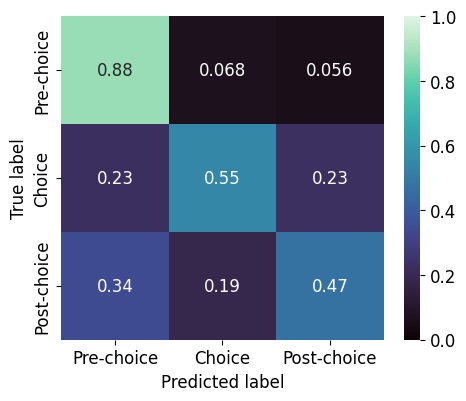

F1 results 0.6301703163017032


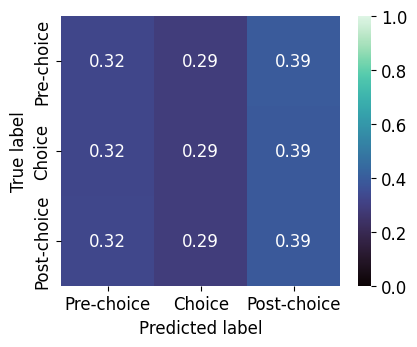

F1 shuffled results 0.33213300892133013


In [22]:
"""
PLOT RESULTS
"""

# -- Confusion Matrix
labels = np.array(mat[var])

# Results on original model
plt.rc('font', size=12) 
plt.figure(figsize=[5.2, 4.2])
hmap = sns.color_palette("mako", as_cmap=True)
data = decoding_result.loc[decoding_result['shuffle'] == 0]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels.astype(int)), xticklabels=np.unique(labels.astype(int)), 
    cmap= hmap, vmin=0, vmax=1) 
plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('full_cm.svg',dpi=500)
plt.show()
print('F1 results', data['f1'].mean())


# Results from shuffled model
plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 3.5])
# data = decoding_result.loc[decoding_result['shuffle'] == 1]
data = decoding_result.loc[decoding_result['shuffle'] >0]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels), xticklabels=np.unique(labels), 
    cmap= hmap, vmin=0, vmax=1)
plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
print('F1 shuffled results',  data['f1'].mean())



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


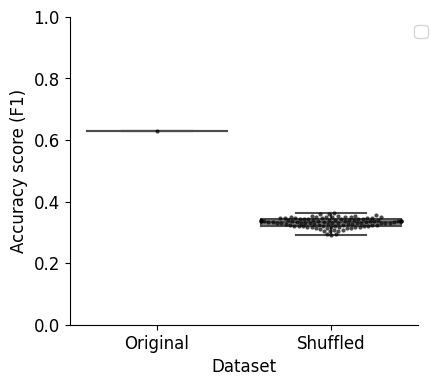

In [23]:
# -- F1 score per model, original and shuffled
data = decoding_result.copy()
data['f1'] = data['f1'].astype(float)

data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
data = data.rename(columns={'shuffle': 'Dataset'})

plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 4])
sns.boxplot(y='f1', x='Dataset', data=data, color='grey') 
sns.swarmplot(y='f1', x='Dataset', data=data, color='black', dodge=True, alpha=0.7, size=3)
plt.ylim([0,1])
plt.ylabel('Accuracy score (F1)')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(top=True, right=True)
#plt.savefig('violin.svg',dpi=500)

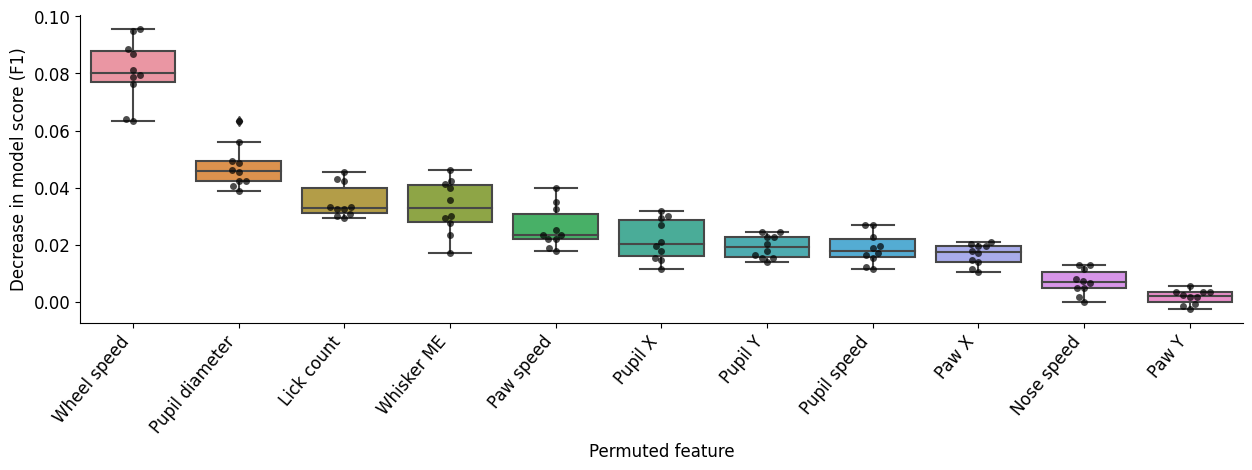

In [24]:
# -- Permutation tests for full model
f1_full_model = decoding_result.loc[decoding_result['shuffle']==0, 'f1'][0]
data = permutation_result.copy()
data['f1'] = data['f1'].astype(float)
data['f1'] = original_f1 - data['f1']
data = data.replace(var_names, ['Wheel speed', 'Pupil diameter',
    'Whisker ME', 'Nose speed', 'Paw speed', 
    'Paw X', 'Paw Y',
    'Pupil speed', 'Pupil X', 'Pupil Y', 'Lick count'])

plot_order = data.groupby('feature')['f1'].mean().sort_values(ascending=False).index.values
plt.figure(figsize=[15,4])
plt.rc('font', size=12) 
sns.boxplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v') 
sns.swarmplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v', color='black', alpha=0.7) 
plt.xlabel('Permuted feature')
plt.ylabel('Decrease in model score (F1)')
ha = 'right'
plt.xticks(rotation=50, ha=ha)
sns.despine(top=True, right=True)
plt.savefig('permutation_importances.svg',dpi=500)
